### Developing calibration curves for WellSTICs

This notebook presents one example of a building a calibration curve for a single WellSTIC using 4 separate calibration
solutions: 23 uS/cm, 84 uS/cm, 447 uS/cm and 1413 uS/cm. First, each solution was cooled to ~5 deg C. The WellSTIC was
suspended in the cooled solution and made measurements every 1 minute while it warmed up to room temperature. We then
use the temperature and intensity for each observation to build a relationship between electrical conductivity and
intensity/temperature. For more details see [Gillman et al. (2013)](https://doi.org/10.1002/2017WR020634).

### First, read in the hobo data and plot it
(Note that .hobo files have been converted to .csv using the bulk file export tool.)

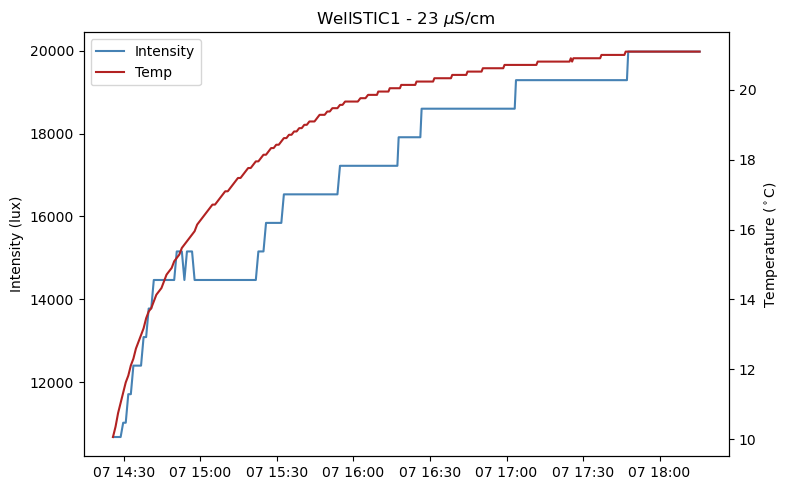

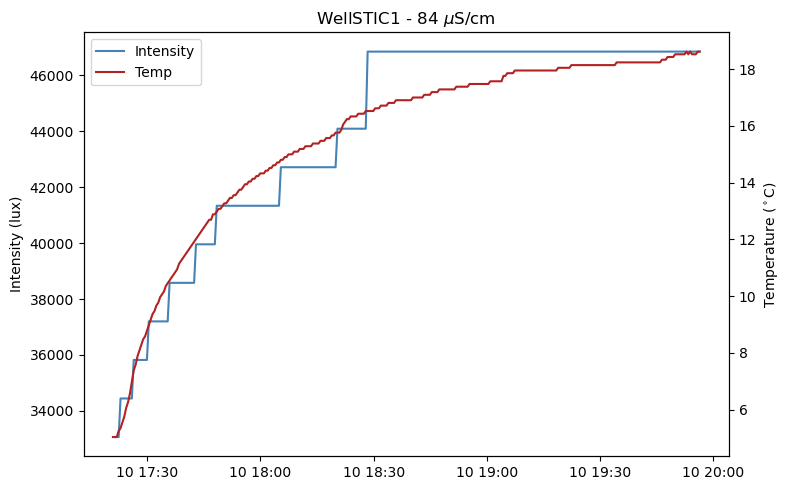

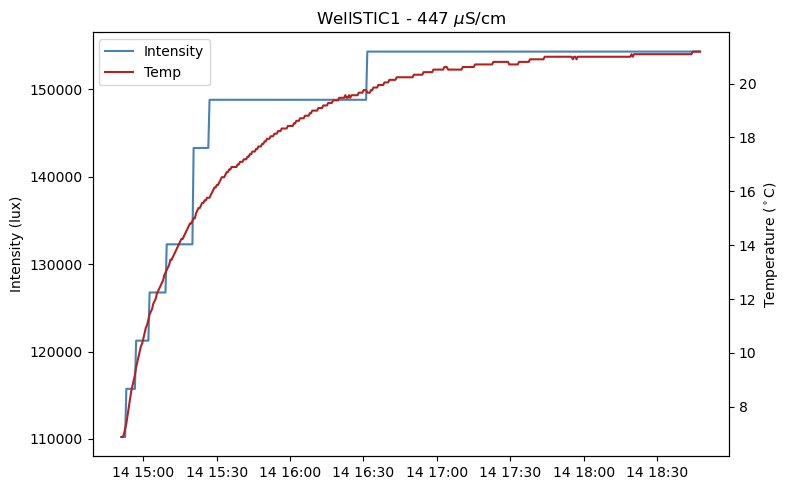

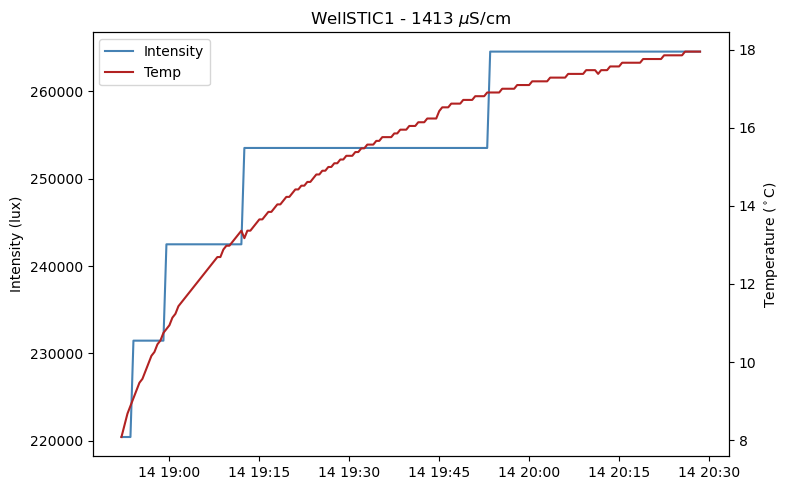

In [1]:
from src.wellstic import *

# List of specific conductance of each calibration solution
SpCs = [23, 84, 447, 1413]

# Read in csv data for each calibration solution and plot it
for i, SpC in enumerate(SpCs):
    # WellSTIC data from each calibration solution is in the format:
    #     '../calibration_data/WellSTIC1_%suScm.csv' % specific_conductance
    infile = '../hobo_data/calibration/WellSTIC1_%suScm.csv' % SpC

    # Read in the csv file, only using the first 3 columns, skipping an extra couple
    # header rows, and using the date/time column as the index
    hobo_df = pd.read_csv(infile, usecols=[1,2,3],
                          names=['datetime', 'Temp', 'Intensity'], parse_dates=[0],
                          skiprows=2, index_col=[0])

    # Drop NaN values (usually these are events, like when the coupler is connected)
    hobo_df.dropna(inplace=True)

    # There is some "ringing" in the 23 uS/cm file, so filter out those values
    if SpC == 23:
        hobo_df = filter_ringing(hobo_df)

    # Calculate electrical conductivity of the reference solution given temperature
    hobo_df['EC'] = convert_to_ec(hobo_df['Temp'], SpC)

    # Plot the intensity and temperature values to check on them
    fig, ax = plot_intensitytemp(hobo_df)
    ax.set(title='WellSTIC1 - %d $\mu$S/cm' % SpC)

    # Append all SpC data to a single dataframe
    if i == 0:
        df = hobo_df.copy()
    else:
        df = pd.concat([df, hobo_df], axis=0)


### Next, plot all observations in a single EC vs Intensity curve

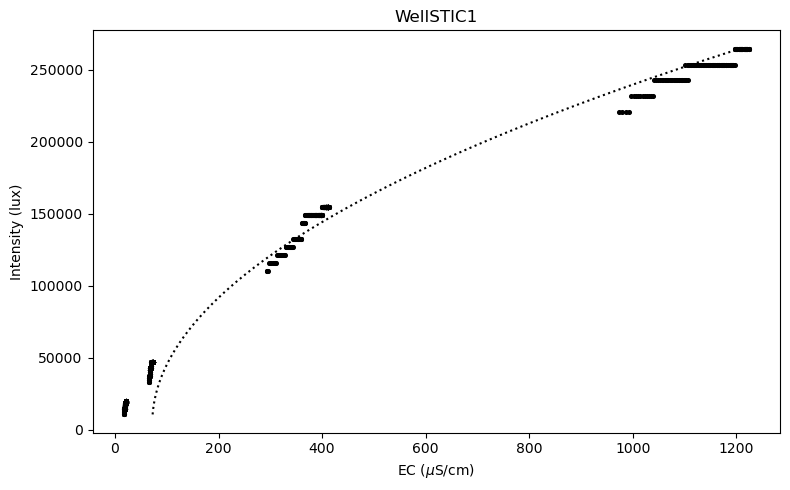

In [2]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True, facecolor='white')

# Show scatter plot of data
ax.scatter(df['EC'], df['Intensity'], s=7, color='k')
ax.set(xlabel='EC ($\mu$S/cm)', ylabel='Intensity (lux)', title='WellSTIC1')

# Fit a curve to it, using wellstic.fit_predict
X = df[['Temp', 'Intensity']].values
y = df['EC'].values

# X1 is the range of 'Temp' and 'Intensity' values on which we are predicting
X1 = np.linspace(np.amin(X, axis=0), np.amax(X, axis=0), num=200)
y_hat = fit_predict(X, y, X1)
ax.plot(y_hat, X1[:, 1], color='k', linestyle=':')

### Finally, save the fit coefficients for use later on

In [3]:
# Fit polynomial curve to the data
X = df[['Temp', 'Intensity']].values
y = df['EC'].values
coefs = fit(X, y)['x']
np.save('../calibration_coefficients/WellSTIC1_CalibrationCoefficients.npy', coefs)

# Also calculate adjusted R-squared, and the covariance matrix of the fit
# These values are useful for error propagation
adj_rsq, sr, covb = fit_statistics(X, y)
np.save('../calibration_coefficients/WellSTIC1_covb.npy', covb)